# Lab 05: A Simple Internal Structure Model for Earth (or any planet)

S.T. Stewart<br>
sts@ucdavis.edu<br>
May 5, 2020

## A simple 2-layer planet

Our model planet will be comprised of two layers: a silicate mantle and iron core. We will begin with very primitive models and improve them using different types of information (observations) and assumptions.

Here, we focus on forward-modeling a planetary structure to compare to available information. This is a useful approach when learning to develop your intuition and understanding of concepts. In practice, more complete interior structure models are obtained by solving an inverse problem.

This exercise assumes you have experience reading in data, making plots, writing data to a file, and saving plots in different formats in a Jupyter notebook.

We will use the calculation of Earth's interior structure as our example and compare the calculation to the Preliminary Reference Earth Model (PREM).


In [1]:
# This is a code cell
# In code cells, # denotes the start of comments

# Python is a computer language that is experiencing rapid development; sometimes features change or disappear
# recording the version information makes sure that your calculations are reproducible
# Record the verion information for these calculations for posterity
# Not all of these packages should be imported in total, 
# so they are deleted after the version information is extracted
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy

# Import only the python libraries that we need 
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import numpy as np
from scipy.interpolate import interp1d
#from mpl_toolkits.axes_grid1 import make_axes_locatable

#plt.rcParams["figure.figsize"] = (20,18) # default figure size in inches for our 2x2 subplots

python version:  3.6.10
matplotlib version:  3.1.2
numpy version:  1.18.1
scipy version:  1.4.1


In [2]:
# Declare some standard variables to be consistent with the PREM model we will be using
# We will use MKS units
G = 6.67E-11 # Gravitational constant  m3/kg/s2
Mearth = 5.972E24 # Earth's mass kg
Rearth = 6371.E3  # Earth's radius m (from PREM)
Rcmb   = 3480000. # CMB radius in m (from PREM)
Iearth = 0.3308*Mearth*Rearth**2 # Earth's moment of inertia kg m2 from https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html


## We will use PREM as a reference and input for our calculations

PREM is a one-dimensional average structure model for the Earth developed from seismic data. The original reference is:<br>
<b>Dziewonski, A. M., and D. L. Anderson. 1981. "Preliminary reference Earth model." Phys. Earth Plan. Int. 25:297-356.</b>

The 1D model has been updated by Panning and Romanowicz (2006). Download the Modified PREM model from the <a href="http://ds.iris.edu/spud/earthmodel/9785674">IRIS web site</a>.

There are three different data formats. Download the "The model in comma separated value (CSV) IDV file format". I like this file format because it includes the units in the file header. The file name is PREM500_IDV.csv

You can open the file in the Jupyter environment by going back to the file browser. Take a moment now and open the PREM file in your web browser.

The beginning of the file is:<br>
`
(index -> (radius,density,Vpv,Vsv,Q-kappa,Q-mu,Vph,Vsh,eta))
radius[unit="m"],density[unit="kg/m^3"],Vpv[unit="m/s"],Vsv[unit="m/s"],Q-kappa[unit=""],Q-mu[unit=""],Vph[unit="m/s"],Vsh[unit="m/s"],eta[unit=""]
`


This header is followed by comma separated columns of numbers. The first column is radius of the Earth with zero at the center. We will use only the vertical components of the p and s wave velocities. If you compare the vertical and horizontal values, you will see that they only vary in the lithosphere, and we will be neglecting these details in this exercise.

In [3]:
# code cell
# Read in PREM: Preliminary Earth Reference Model
PREM_filename='PREM500_IDV.csv' # we love long, readable variable names!

# there are several different ways to read in this data
# let's just read in all the data columns
# skip the first 2 fows
PREM_alldata = np.loadtxt(PREM_filename,delimiter=',',skiprows=2)

# Let's examine this variable now
print('The shape of the array PREM_ALLdata: ',PREM_alldata.shape)


The shape of the array PREM_ALLdata:  (504, 9)


PREM_ALLdata is a 2-dimensional array. The first index has 504 entries which translates to 504 depths (radii) in the Earth. The second index is the number of variables for each entry: radius, density, etc.

The annoying part is you need to remember what each index corresponds to, so we will group our variables together in a class object.

In [4]:
# make a class to hold the model planet: same class for the PREM data and our model planet
# the class also holds derived variables related to the radial structure of the planet (gravity; pressure)
class PLANETclass:
    """Class to hold PLANET MODEL data."""   # this is a documentation string for this class
    def __init__(self): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.NR       = 0                    # number of radius points; initialize with no points
        self.radius   = np.zeros(self.NR) 
        self.density  = np.zeros(self.NR)   
        self.pwavevel = np.zeros(self.NR)    # using vertical components of p and s waves
        self.swavevel = np.zeros(self.NR)
        self.pressure = np.zeros(self.NR)    # prepare to populate this structure with derived variables
        self.gravity  = np.zeros(self.NR)
        self.dr       = np.zeros(self.NR)
        self.massperlayer = np.zeros(self.NR)
        self.K            = np.zeros(self.NR) # Bulk modulus Pa
        self.G            = np.zeros(self.NR) # Shear modulus Pa
        self.phi          = np.zeros(self.NR) # Adams-Williamson parameter
        self.M = 0 # total mass
        self.I = 0 # moment of inertia C/MR2
        # not going to use all the variables in the PREM file
        self.units = '' # I like to keep a text note in a structure about the units

        

Now initialize a variable as a PREM object class and assign the data into the variable. Classes are the basis for object-oriented programming in python. Our PREM object is basically a simple structure to hold variables and make it intuitive to read the code. Later we can extend it to include a function.

In [5]:
# code cell
# initialize an empty PLANET object that we will fill with the PREM model
PREM = PLANETclass()

# Classes have a whole set of special built in objects
help(PREM)
# note that the comments in the class definition are printed by help.

# read the data into the class parameters
PREM.radius = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[0]) # radius in m
PREM.density = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[1]) # density in kg/m3
PREM.pwavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[2]) # p-wave velocity m/s vertical component
PREM.swavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[3]) # s-wave velocity m/s vertical component
PREM.NR = len(PREM.radius) # number of radius points
# I like to put the units in the structure so I can easily remind myself and double check units while using these data
PREM.units = 'radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s), pressure (Pa), gravity (m/s2), dr (m), massperlayer (kg), K (Pa), G (Pa), phi (m2/s2), M (kg), I (M/R2)'

# now loop through the PREM data and populate the rest of the variables
PREM.gravity = np.zeros(PREM.NR)
PREM.pressure = np.zeros(PREM.NR)
PREM.dr = np.zeros(PREM.NR)
PREM.massperlayer = np.zeros(PREM.NR)
for i in range(1,PREM.NR,1): # loop from center to surface
    PREM.dr[i]           = PREM.radius[i]-PREM.radius[i-1]
    PREM.massperlayer[i] = 4.*3.14159*PREM.density[i-1]*PREM.dr[i]*PREM.radius[i]**2
    PREM.gravity[i]      = G*np.sum(PREM.massperlayer[0:i])/PREM.radius[i]/PREM.radius[i]
for i in range(PREM.NR-2,0,-1): # loop from surface to center
    PREM.pressure[i]     = PREM.pressure[i+1]+PREM.density[i]*PREM.gravity[i]*PREM.dr[i]
# for aesthetic reasons, enter the central pressure value in the array
PREM.pressure[0]=PREM.pressure[1]


### STUDENT:
# calculate total mass
PREM.M = np.sum(PREM.massperlayer)
# calculate moment of inertia
for i in range(1, PREM.NR, 1):
    PREM.I += 2 / 3.0 * PREM.massperlayer[i] * PREM.radius[i]**2.0
PREM.I = PREM.I / (PREM.M*Rearth**2.0)

print('Total mass (Mearth)=',PREM.M/Mearth)
print('Moment of inertia (C/MR2)=',PREM.I)

print('The shape of the radius array: ',PREM.radius.shape)
print('The first 10 values in radius: ',PREM.radius[0:10])
print('Units: ',PREM.units)

# Take a moment to inspect the PREM structure, print PREM.NR, print more values, etc.

Help on PLANETclass in module __main__ object:

class PLANETclass(builtins.object)
 |  Class to hold PLANET MODEL data.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      A function to initialize the class object.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

Total mass (Mearth)= 1.004603061555901
Moment of inertia (C/MR2)= 0.33147240875757783
The shape of the radius array:  (504,)
The first 10 values in radius:  [     0.  12858.  25716.  38574.  51432.  64289.  77147.  90005. 102863.
 115721.]
Units:  radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s), pressure (Pa), gravity (m/s2), dr (m), massperlayer (kg), K (Pa), G (Pa), phi (m2/s2), M (kg), I (M/R2)


Now let's make some plots of the PREM data. We will make multiple plots, so we will use the subplots feature in matplotlib.


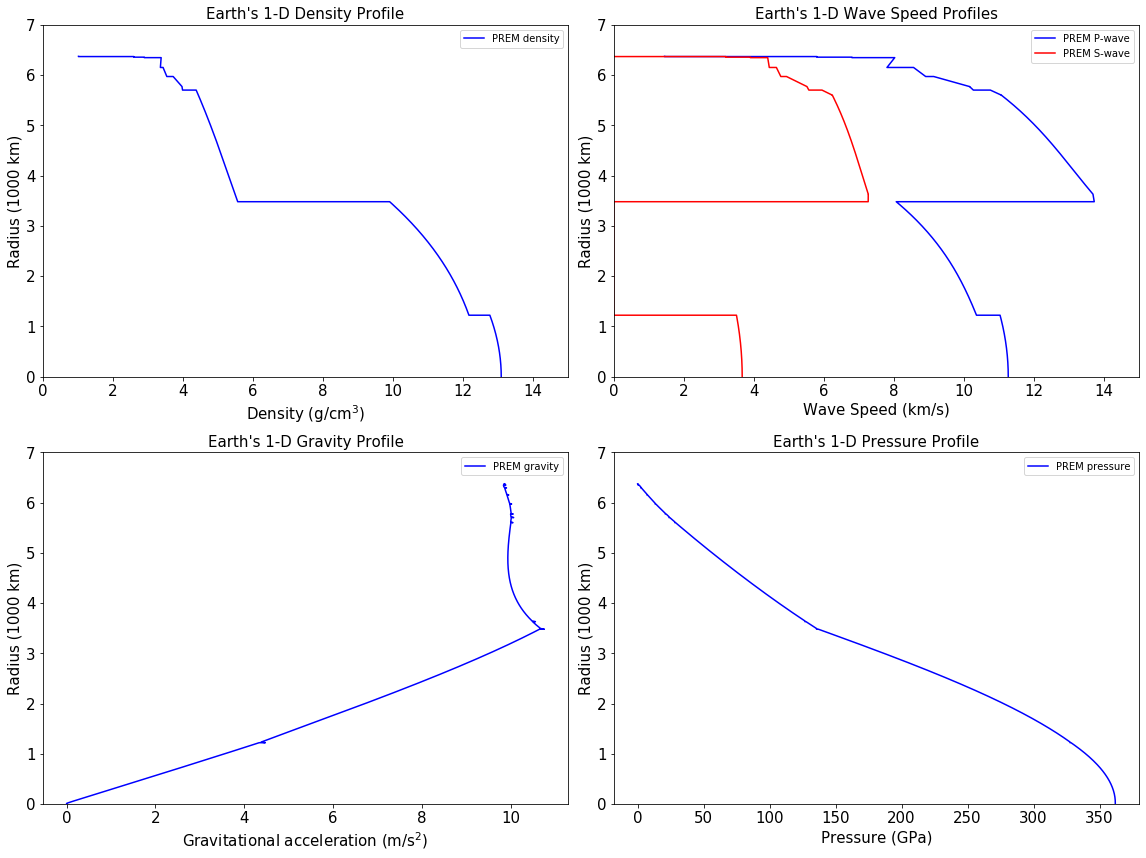

In [6]:
# Now let's make some plots of the PREM data
# example of making 2x3 grid of subplots in a 14x18 inch plot
#fig, ([ax0, ax1], [ax2,ax3], [ax4,ax5])= plt.subplots(nrows=3,ncols=2,figsize=(14,18))

sfont=15 # I like to set the size of my fonts

# make 4 plots to show the different variables in the structure
fig, ([ax0, ax1], [ax2, ax3])= plt.subplots(ncols=2,nrows=2,figsize=(16,12))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.density/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM density')
ax0.set_ylim(0.,7)
ax0.set_xlim(0,15.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Density Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: p-wave, s-wave vels vs. radius
# change units to km/s and 1000 km
ax1.plot(PREM.pwavevel/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM P-wave')
ax1.plot(PREM.swavevel/1.E3,PREM.radius/1.E6,'-',color='red',label='PREM S-wave')
ax1.set_ylim(0.,7)
ax1.set_xlim(0,15.)
ax1.set_xlabel('Wave Speed (km/s)',size=sfont)
ax1.set_ylabel('Radius (1000 km)',size=sfont)
ax1.set_title('Earth\'s 1-D Wave Speed Profiles',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# third subplot: gravitational acceleration vs. radius
# change units to 1000 km
ax2.plot(PREM.gravity,PREM.radius/1.E6,'-',color='blue',label='PREM gravity')
ax2.set_ylim(0.,7)
ax2.set_xlabel('Gravitational acceleration (m/s$^2$)',size=sfont)
ax2.set_ylabel('Radius (1000 km)',size=sfont)
ax2.set_title('Earth\'s 1-D Gravity Profile',size=sfont)
ax2.tick_params(labelsize=sfont)
ax2.legend(fontsize=sfont-5)

# fourth subplot: pressure vs. radius
# change units to GPa and 1000 km
ax3.plot(PREM.pressure/1.e9,PREM.radius/1.E6,'-',color='blue',label='PREM pressure')
ax3.set_ylim(0.,7)
ax3.set_xlabel('Pressure (GPa)',size=sfont)
ax3.set_ylabel('Radius (1000 km)',size=sfont)
ax3.set_title('Earth\'s 1-D Pressure Profile',size=sfont)
ax3.tick_params(labelsize=sfont)
ax3.legend(fontsize=sfont-5)


# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)

# this saves a pdf file -- vector graphics are preferred
plt.savefig('PREM-plot.pdf', format='pdf', dpi=300,transparent=True)

# this is saving a png file -- raster graphics need to be very high resolution for crisp text
plt.savefig('PREM-plot.png', format='png', dpi=300,transparent=False)


# Part 1
# Derive the bulk and shear modulus profile for the Earth from the PREM data

These body wave velocities are related to the compressibility and rigidity moduli of the materials in each layer.

The p-wave velocity is related to the isentropic bulk modulus $K$ by:
$v_p = \sqrt{\frac{K + (4/3)G}{\rho}}$

The s-wave velocity is related to the shear modulus $G$ by:
$v_s = \sqrt{\frac{G}{\rho}}$

where,
$K = -V\frac{dP}{dV} = \rho \frac{dP}{d\rho}$

Plot the bulk modulus and shear modulus vs. radius from the PREM data.

## calculate and plot
A. K(R) and G(R)<br>
B. G(R)/K(R)<br>
C. K(P)<br>
D. G(P)

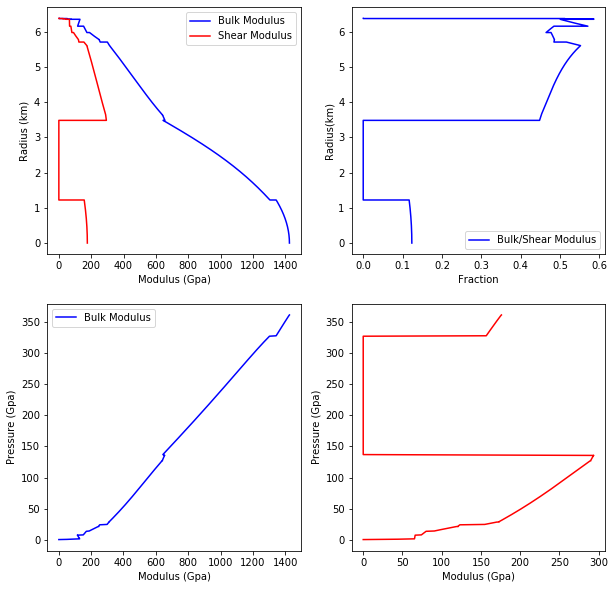

In [7]:
# calculate and plot here
# compute modulus
Gpa = 1e9  # Gpa to pa
K = PREM.density * (PREM.pwavevel**2.0 - 4.0 / 3.0 * PREM.swavevel**2.0)
_G = PREM.density * PREM.swavevel**2.0
PREM.K = K.copy()
PREM.G = _G.copy()
fig, axs = plt.subplots(2, 2, figsize = (10.0, 10.0))
axs[0, 0].plot(K/Gpa, PREM.radius/1e6, 'b', label='Bulk Modulus')  # plot the modulus
axs[0, 0].plot(_G/Gpa, PREM.radius/1e6, 'r', label='Shear Modulus')
axs[0, 0].set_ylabel('Radius (km)')
axs[0, 0].set_xlabel('Modulus (Gpa)')
axs[0, 0].legend()
axs[0, 1].plot(_G/K, PREM.radius/1e6, 'b', label='Bulk/Shear Modulus')  # plot the fraction of the two modulus
axs[0, 1].set_xlabel('Fraction')
axs[0, 1].set_ylabel('Radius(km)')
axs[0, 1].legend()
axs[1, 0].plot(K/Gpa, PREM.pressure/Gpa, 'b', label="Bulk Modulus")  # plot the bulk modulus vs pressure
axs[1, 0].set_ylabel('Pressure (Gpa)')
axs[1, 0].set_xlabel('Modulus (Gpa)')
axs[1, 0].legend()
axs[1, 1].plot(_G/Gpa, PREM.pressure/Gpa, 'r', label="Shear Modulus")  # plot the bulk modulus vs pressure
axs[1, 1].set_ylabel('Pressure (Gpa)')
axs[1, 1].set_xlabel('Modulus (Gpa)')
fig.show()

# Fit a lines to K(P)

Fit onlye the lower mantle and the liquid core.
You can use the np.where command to select the regions of the radius array that you want.

For example,

mind = np.where(((PREM.radius > Rcmb) & (PREM.radius < 5600.e3)))

returns the indices that correspond to the mantle.

res = np.polyfit(PREM.pressure[mind],PREM.K[mind],1)

Kfit = res[0]*PREM.pressure+res[1]

The slope of the line is similar for different geologic materials. That is, the first order pressure-dependence on the bulk moduli is similar for different geologic materials.

(array([274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438]),)


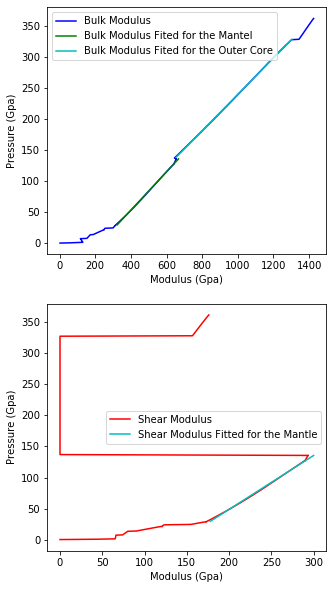

In [8]:
# fit the curves
Rinner_core = 1220e3
mind = np.where(((PREM.radius > Rcmb) & (PREM.radius < 5600.e3)))
print(mind)
# returns the indices that correspond to the mantle.
res_K = np.polyfit(PREM.pressure[mind], PREM.K[mind],1)
Kfit = res_K[0]*PREM.pressure+res_K[1]
res_G = np.polyfit(PREM.pressure[mind], PREM.G[mind],1)
Gfit = res_G[0]*PREM.pressure+res_G[1]
# returns the indices that correspond to the outer.
mind_outer_core = np.where(((PREM.radius < Rcmb) & (PREM.radius > Rinner_core)))
res_K_outer_core = np.polyfit(PREM.pressure[mind_outer_core], PREM.K[mind_outer_core],1)
Kfit_outer_core = res_K_outer_core[0]*PREM.pressure+res_K_outer_core[1]
# Plot alongside original ploting
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

axs[0].plot(K/Gpa, PREM.pressure/Gpa, 'b', label="Bulk Modulus")  # plot the bulk modulus vs pressure
axs[0].plot(Kfit[mind]/Gpa, PREM.pressure[mind]/Gpa, 'g', label="Bulk Modulus Fited for the Mantel")  # plot the fit
axs[0].plot(Kfit_outer_core[mind_outer_core]/Gpa, PREM.pressure[mind_outer_core]/Gpa, 'c', label="Bulk Modulus Fited for the Outer Core")  # plot the fit
axs[0].set_ylabel('Pressure (Gpa)')
axs[0].set_xlabel('Modulus (Gpa)')
axs[0].legend()
axs[1].plot(_G/Gpa, PREM.pressure/Gpa, 'r', label="Shear Modulus")  # plot the bulk modulus vs pressure
axs[1].plot(Gfit[mind]/Gpa, PREM.pressure[mind]/Gpa, 'c', label="Shear Modulus Fitted for the Mantle")  # plot the fit
axs[1].set_ylabel('Pressure (Gpa)')
axs[1].set_xlabel('Modulus (Gpa)')
axs[1].legend()
fig.show()

# Part 2A: A CONSTANT-DENSITY 2-LAYER PLANET STRUCTURE
Assume a simple two-layer planet with constant density layers.
Yes, this is a poor model for a planet, but we will refine it in a moment.

We will use these constraints: Earth's surface radius; total mass; principal moment of inertia.

These are all variables that can be determined for any planet (with a moon's orbit to constrain the planet mass and a gravity field measurement to constrain the moments of inertia).

For convenience, use the same class structure:

MYPLANET = PLANETclass()

We will use the same radius array as the PREM data. Then we can easily use the same seismic velocities as a constraint on our planet model in the next step.

MYPLANET.radius   = PREM.radius<br>

## Initialize a 2-layer planet:
Generate a planet class objects with density(R), P(R), g(R).<br>
Calculate total mass and the moment of inertia.<br>
Sum the spherical shells to determine the total moment of inertia and calculate the prefactor (I/(MR$^2$)) to compare to the observed value.

Make the same 4 plots that we have for the PREM planet above: rho(R), (wave speeds will come in a minute; for now plot zeros), P(R), g(r).<br>
Overplot the PREM data to your simple planet for comparison (copy the plotting code from above).


Total mass (Mearth)= 0.0
Moment of inertia (C/MR2)= 0


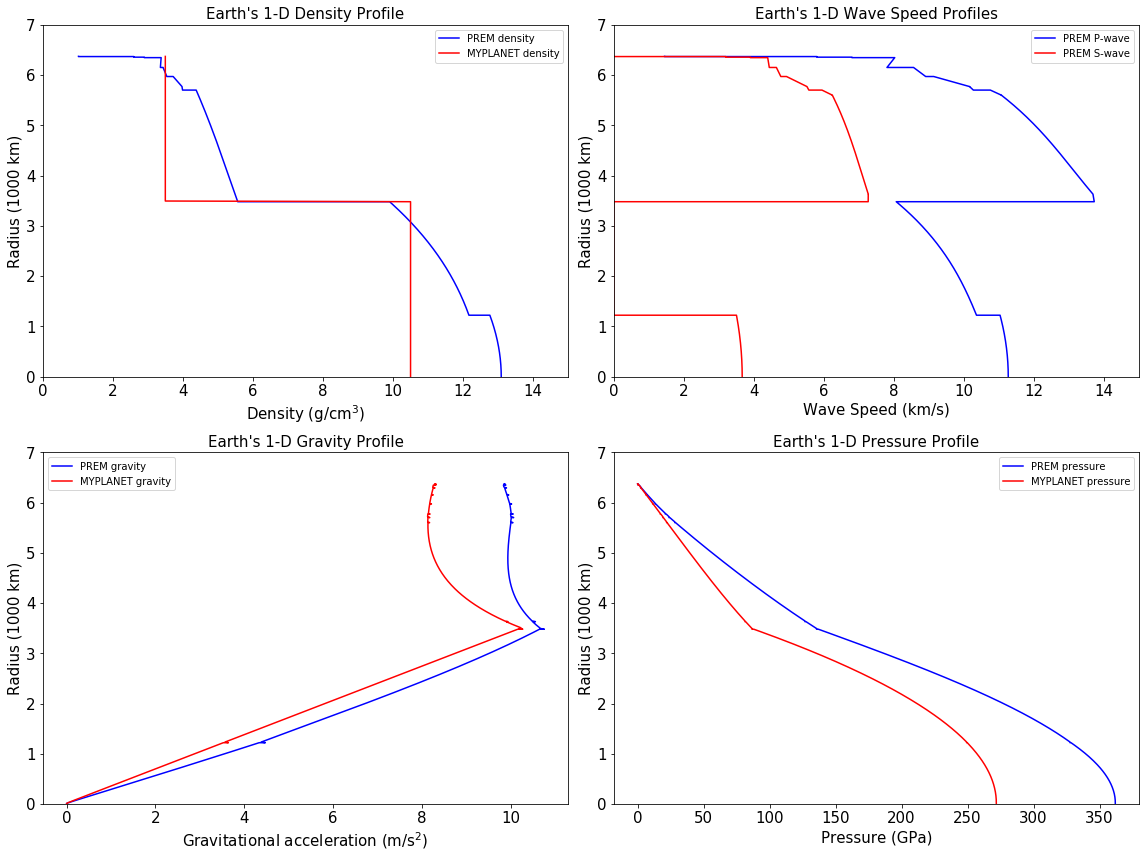

In [9]:
# initialize an empty PLANET object that we will fill with the our simple planet model
# G = 6.67E-11
MYPLANET = PLANETclass()
# for convenience we will use the same radius array as the PREM data
# then we can easily use the same seismic velocities as a constraint on our planet model

MYPLANET.NR       = PREM.NR
MYPLANET.density  = np.zeros(MYPLANET.NR)

MYPLANET.radius   = PREM.radius
MYPLANET.dr       = PREM.dr
MYPLANET.pwavevel = PREM.pwavevel # we will not use these wave speeds yet; will use below
MYPLANET.swavevel = PREM.swavevel

# guess 4 initial values to make a planet
rhomantle = 3500.      # kg/m3
rhocore = rhomantle*3. # kg/m3
Rplanet = Rearth
Rcore = Rcmb           # feel free to change this when just playing around to see how the outputs change

# calculate the structure of our simple planet and compare to PREM
ind = np.where(MYPLANET.radius > Rcore)
MYPLANET.density[ind]=rhomantle
ind = np.where(MYPLANET.radius <= Rcore)
MYPLANET.density[ind]=rhocore

# now loop through the structure data and populate the rest of the variables
MYPLANET.gravity = np.zeros(MYPLANET.NR)
MYPLANET.pressure = np.zeros(MYPLANET.NR)
MYPLANET.massperlayer = np.zeros(MYPLANET.NR)

#### INSERT YOUR CODE HERE FOR gravity, pressure, M, I
MYPLANET.gravity = np.zeros(MYPLANET.NR)
MYPLANET.pressure = np.zeros(MYPLANET.NR)
MYPLANET.dr = np.zeros(MYPLANET.NR)
MYPLANET.massperlayer = np.zeros(MYPLANET.NR)
for i in range(1,MYPLANET.NR,1): # loop from center to surface
    MYPLANET.dr[i]           = MYPLANET.radius[i]-MYPLANET.radius[i-1]
    MYPLANET.massperlayer[i] = 4.*3.14159*MYPLANET.density[i-1]*MYPLANET.dr[i]*MYPLANET.radius[i]**2
    MYPLANET.gravity[i]      = G*np.sum(MYPLANET.massperlayer[0:i])/MYPLANET.radius[i]/MYPLANET.radius[i]
for i in range(MYPLANET.NR-2,0,-1): # loop from surface to center
    MYPLANET.pressure[i]     = MYPLANET.pressure[i+1]+MYPLANET.density[i]*MYPLANET.gravity[i]*MYPLANET.dr[i]
# for aesthetic reasons, enter the central pressure value in the array
MYPLANET.pressure[0]=MYPLANET.pressure[1]



print('Total mass (Mearth)=',MYPLANET.M/Mearth)
print('Moment of inertia (C/MR2)=',MYPLANET.I)



# Now let's make some plots of the planet
sfont=15 # I like to set the size of my fonts

# make 4 plots to show the different variables in the structure
fig, ([ax0, ax1], [ax2, ax3])= plt.subplots(ncols=2,nrows=2,figsize=(16,12))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.density/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM density')
ax0.plot(MYPLANET.density/1.E3,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET density')
ax0.set_ylim(0.,7)
ax0.set_xlim(0,15.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Density Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: p-wave, s-wave vels vs. radius
# change units to km/s and 1000 km
ax1.plot(PREM.pwavevel/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM P-wave')
ax1.plot(PREM.swavevel/1.E3,PREM.radius/1.E6,'-',color='red',label='PREM S-wave')
ax1.set_ylim(0.,7)
ax1.set_xlim(0,15.)
ax1.set_xlabel('Wave Speed (km/s)',size=sfont)
ax1.set_ylabel('Radius (1000 km)',size=sfont)
ax1.set_title('Earth\'s 1-D Wave Speed Profiles',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# third subplot: gravitational acceleration vs. radius
# change units to 1000 km
ax2.plot(PREM.gravity,PREM.radius/1.E6,'-',color='blue',label='PREM gravity')
ax2.plot(MYPLANET.gravity,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET gravity')
ax2.set_ylim(0.,7)
ax2.set_xlabel('Gravitational acceleration (m/s$^2$)',size=sfont)
ax2.set_ylabel('Radius (1000 km)',size=sfont)
ax2.set_title('Earth\'s 1-D Gravity Profile',size=sfont)
ax2.tick_params(labelsize=sfont)
ax2.legend(fontsize=sfont-5)

# fourth subplot: pressure vs. radius
# change units to GPa and 1000 km
ax3.plot(PREM.pressure/1.e9,PREM.radius/1.E6,'-',color='blue',label='PREM pressure')
ax3.plot(MYPLANET.pressure/1.e9,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET pressure')
ax3.set_ylim(0.,7)
ax3.set_xlabel('Pressure (GPa)',size=sfont)
ax3.set_ylabel('Radius (1000 km)',size=sfont)
ax3.set_title('Earth\'s 1-D Pressure Profile',size=sfont)
ax3.tick_params(labelsize=sfont)
ax3.legend(fontsize=sfont-5)


# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)

# this saves a pdf file -- vector graphics are preferred
plt.savefig('MYPLANET-plot.pdf', format='pdf', dpi=300,transparent=True)

# this is saving a png file -- raster graphics need to be very high resolution for crisp text
plt.savefig('MYPLANET-plot.png', format='png', dpi=300,transparent=False)



# PART 2B: Improve your planet structure: Adams-Williamson equation

## Calculate the density profile from the seismic wave speeds assuming an adiabatic thermal profile in the planet

Now, we will improve the density profile by making it adiabatic instead of constant density.

Starting with hydrostatic equilibrium (see Eq 17.28 in Stacey & Davis):
$-\frac{d\rho}{dr} = \frac{d\rho}{dz} = \frac{d\rho}{dP}\frac{dP}{dz} = \frac{\rho}{K}\rho g = \frac{\rho g}{\phi}$

We will use the Adams-Williamson parameter is $\phi$:

$\phi=\frac{K}{\rho}=v_p^2-\frac{4}{3}v_s^2$

Given the seismic wave speeds (which someone has magically collected for you), improve the density profile by integrating from the surface to the center of the planet. Use your initial constant density value for each layer as the density at the top of the layer (at the surface and the top of the core).

Integrate $\frac{d\rho}{dr}$ to determine $\rho(R)$.

Questions:<br>
* Why is this radial structure adiabatic?<br>
* But wait, I need to know $g(R)$ to do this calculation and it depends on density too!

True, we will start with the estimate of $g(R)$ from our 2-layer constant density model planet, and then iteratively improve it to converge to a solution.

Assume that you are given the wave speeds for your model planet (this was filled in above):<br>
MYPLANET.pwavevel = PREM.pwavevel<br>
MYPLANET.swavevel = PREM.swavevel<br>

In the cell below:
>   code to calculate density using Adams-Williamson parameter<p>
   
>   code to recalculate gravity(R) and pressure(R)<p>
     
>   print total mass and moment of inertia
    
>   plot rho(R), wave speeds, g(R), and p(R) and compare to PREM

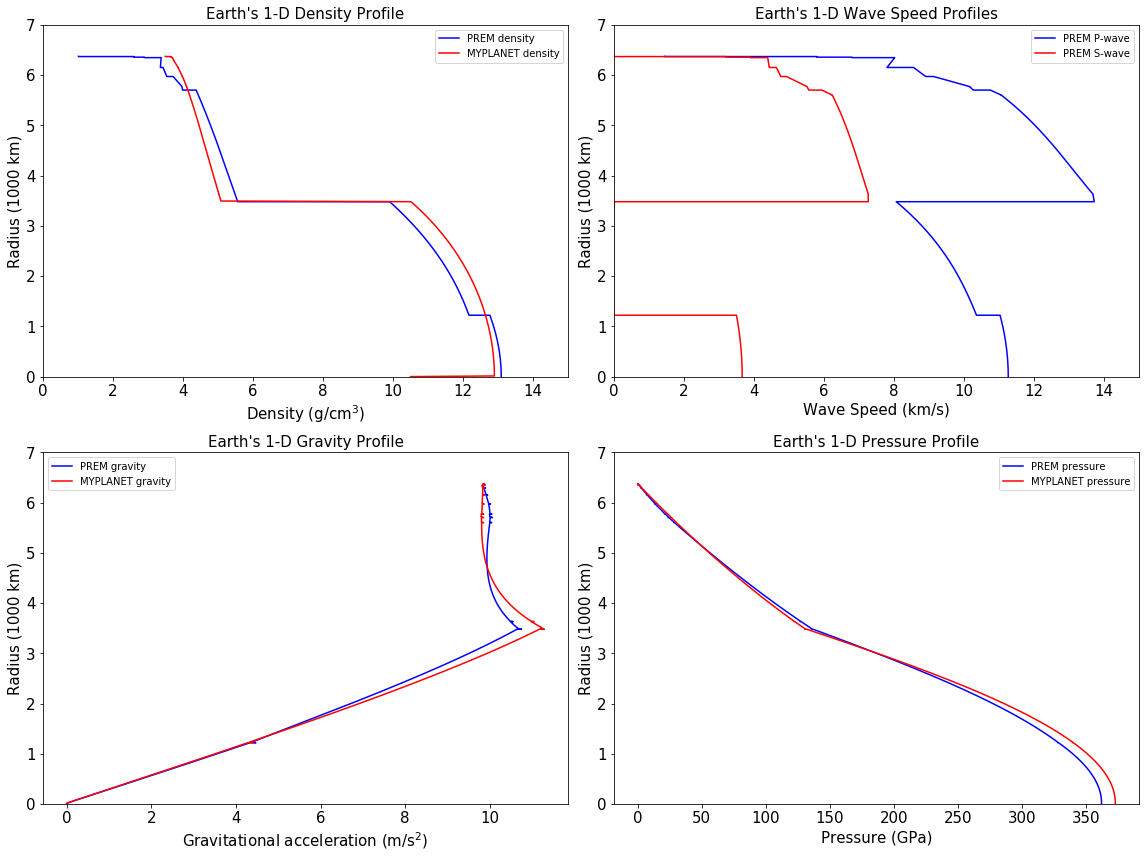

In [10]:
### INSERT YOUR CODE HERE

# Calculate phi and then calculate rho(R) in a single loop using the g(R) from your constant-density planet
MYPLANET.phi = MYPLANET.pwavevel**2.0 - 4.0/3.0 * MYPLANET.swavevel**2.0

# guess 4 initial values to make a planet
rhomantle = 3500.      # kg/m3
rhocore = rhomantle*3. # kg/m3
Rplanet = Rearth
Rcore = Rcmb           # feel free to change this when just playing around to see how the outputs change

# calculate the structure of our simple planet and compare to PREM
ind = np.where(MYPLANET.radius > Rcore)
MYPLANET.density[ind]=rhomantle
ind = np.where(MYPLANET.radius <= Rcore)
MYPLANET.density[ind]=rhocore

# now loop through the structure data and populate the rest of the variables

def updateStates(MYPLANET):
    for i in range(MYPLANET.NR-2, np.max(ind), -1):
        MYPLANET.density[i] = MYPLANET.density[i+1] + MYPLANET.dr[i] * MYPLANET.density[i+1] * MYPLANET.gravity[i+1] / MYPLANET.phi[i+1]
    for i in range(np.max(ind)-1, 0, -1):
        MYPLANET.density[i] = MYPLANET.density[i+1] + MYPLANET.dr[i] * MYPLANET.density[i+1] * MYPLANET.gravity[i+1] / MYPLANET.phi[i+1]
    for i in range(1,MYPLANET.NR,1): # loop from center to surface
        MYPLANET.massperlayer[i] = 4.*3.14159*MYPLANET.density[i-1]*MYPLANET.dr[i]*MYPLANET.radius[i]**2
        MYPLANET.gravity[i]      = G*np.sum(MYPLANET.massperlayer[0:i])/MYPLANET.radius[i]/MYPLANET.radius[i]
    for i in range(MYPLANET.NR-2,0,-1): # loop from surface to center
        MYPLANET.pressure[i]     = MYPLANET.pressure[i+1]+MYPLANET.density[i]*MYPLANET.gravity[i]*MYPLANET.dr[i]
    # for aesthetic reasons, enter the central pressure value in the array
    MYPLANET.pressure[0]=MYPLANET.pressure[1]  

updateStates(MYPLANET)

# Now let's make some plots of the planet
sfont=15 # I like to set the size of my fonts

# make 4 plots to show the different variables in the structure
fig, ([ax0, ax1], [ax2, ax3])= plt.subplots(ncols=2,nrows=2,figsize=(16,12))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.density/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM density')
ax0.plot(MYPLANET.density/1.E3,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET density')
ax0.set_ylim(0.,7)
ax0.set_xlim(0,15.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Density Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: p-wave, s-wave vels vs. radius
# change units to km/s and 1000 km
ax1.plot(PREM.pwavevel/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM P-wave')
ax1.plot(PREM.swavevel/1.E3,PREM.radius/1.E6,'-',color='red',label='PREM S-wave')
ax1.set_ylim(0.,7)
ax1.set_xlim(0,15.)
ax1.set_xlabel('Wave Speed (km/s)',size=sfont)
ax1.set_ylabel('Radius (1000 km)',size=sfont)
ax1.set_title('Earth\'s 1-D Wave Speed Profiles',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# third subplot: gravitational acceleration vs. radius
# change units to 1000 km
ax2.plot(PREM.gravity,PREM.radius/1.E6,'-',color='blue',label='PREM gravity')
ax2.plot(MYPLANET.gravity,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET gravity')
ax2.set_ylim(0.,7)
ax2.set_xlabel('Gravitational acceleration (m/s$^2$)',size=sfont)
ax2.set_ylabel('Radius (1000 km)',size=sfont)
ax2.set_title('Earth\'s 1-D Gravity Profile',size=sfont)
ax2.tick_params(labelsize=sfont)
ax2.legend(fontsize=sfont-5)

# fourth subplot: pressure vs. radius
# change units to GPa and 1000 km
ax3.plot(PREM.pressure/1.e9,PREM.radius/1.E6,'-',color='blue',label='PREM pressure')
ax3.plot(MYPLANET.pressure/1.e9,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET pressure')
ax3.set_ylim(0.,7)
ax3.set_xlabel('Pressure (GPa)',size=sfont)
ax3.set_ylabel('Radius (1000 km)',size=sfont)
ax3.set_title('Earth\'s 1-D Pressure Profile',size=sfont)
ax3.tick_params(labelsize=sfont)
ax3.legend(fontsize=sfont-5)


# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)

# this saves a pdf file -- vector graphics are preferred
plt.savefig('MYPLANET-plot.pdf', format='pdf', dpi=300,transparent=True)

# this is saving a png file -- raster graphics need to be very high resolution for crisp text
plt.savefig('MYPLANET-plot.png', format='png', dpi=300,transparent=False)



## Now add a convergence loop to bring the density and gravity profiles into agreement

for jj in range(5):<br>
>   code to calculate density using Adams-Williamson parameter<p>
   
>   code to recalculate gravity(R) and pressure(R)<p>
     
>   print total mass and moment of inertia

The values for mass and moment of inertia should asymptote to a fixed value with each loop of jj.
    
You can indent a section of code by highlighting it and hitting tab.

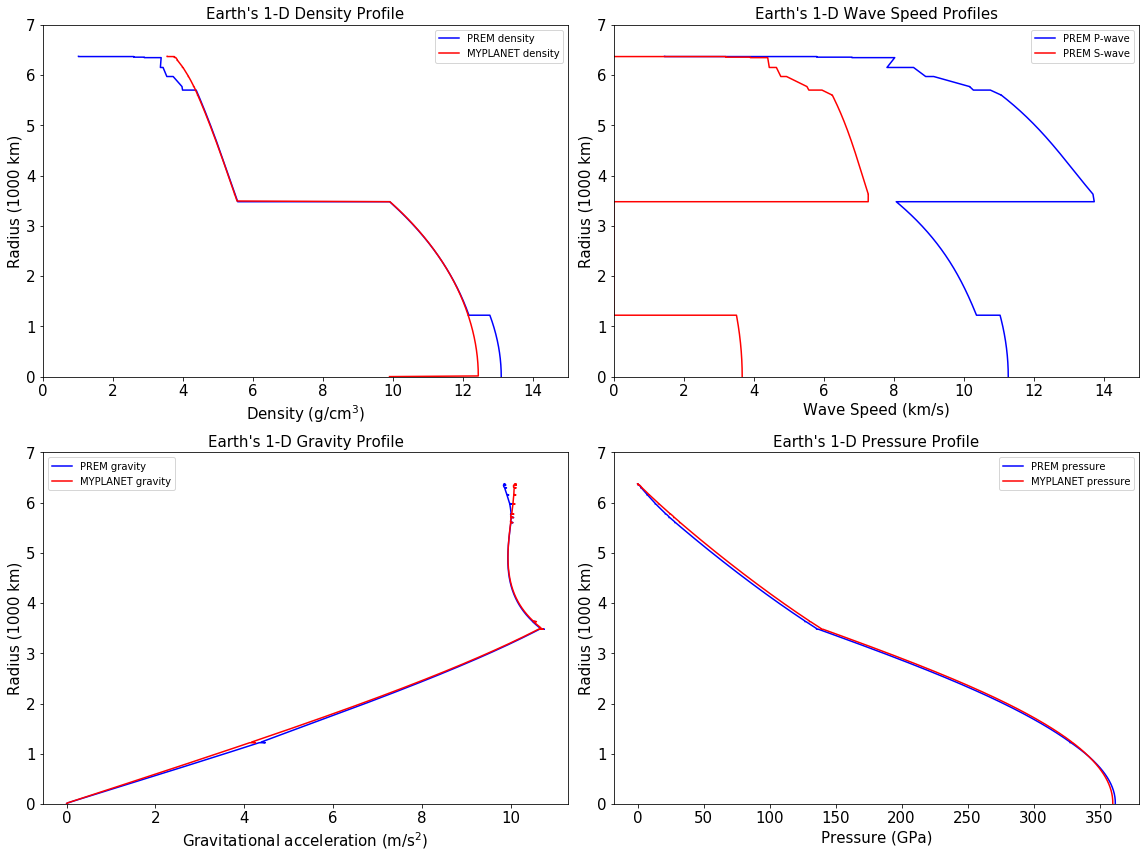

In [11]:
# Calculate phi and then calculate rho(R) in a single loop using the g(R) from your constant-density planet
MYPLANET.phi = MYPLANET.pwavevel**2 - (4/3)*MYPLANET.swavevel**2

# guess 4 initial values to make a planet
rhomantle = 3550.      # kg/m3
rhocore = 9900. # kg/m3
Rplanet = Rearth
Rcore = Rcmb           # feel free to change this when just playing around to see how the outputs change

# calculate the structure of our simple planet and compare to PREM
ind = np.where(MYPLANET.radius > Rcore)
MYPLANET.density[ind]=rhomantle
ind = np.where(MYPLANET.radius <= Rcore)
MYPLANET.density[ind]=rhocore

for jj in range(5):
    updateStates(MYPLANET)
    # loop to make the density array
    # XXX INSERT YOUR CODE HERE

# Now let's make some plots of the planet
sfont=15 # I like to set the size of my fonts

# make 4 plots to show the different variables in the structure
fig, ([ax0, ax1], [ax2, ax3])= plt.subplots(ncols=2,nrows=2,figsize=(16,12))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.density/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM density')
ax0.plot(MYPLANET.density/1.E3,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET density')
ax0.set_ylim(0.,7)
ax0.set_xlim(0,15.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Density Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: p-wave, s-wave vels vs. radius
# change units to km/s and 1000 km
ax1.plot(PREM.pwavevel/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM P-wave')
ax1.plot(PREM.swavevel/1.E3,PREM.radius/1.E6,'-',color='red',label='PREM S-wave')
ax1.set_ylim(0.,7)
ax1.set_xlim(0,15.)
ax1.set_xlabel('Wave Speed (km/s)',size=sfont)
ax1.set_ylabel('Radius (1000 km)',size=sfont)
ax1.set_title('Earth\'s 1-D Wave Speed Profiles',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# third subplot: gravitational acceleration vs. radius
# change units to 1000 km
ax2.plot(PREM.gravity,PREM.radius/1.E6,'-',color='blue',label='PREM gravity')
ax2.plot(MYPLANET.gravity,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET gravity')
ax2.set_ylim(0.,7)
ax2.set_xlabel('Gravitational acceleration (m/s$^2$)',size=sfont)
ax2.set_ylabel('Radius (1000 km)',size=sfont)
ax2.set_title('Earth\'s 1-D Gravity Profile',size=sfont)
ax2.tick_params(labelsize=sfont)
ax2.legend(fontsize=sfont-5)

# fourth subplot: pressure vs. radius
# change units to GPa and 1000 km
ax3.plot(PREM.pressure/1.e9,PREM.radius/1.E6,'-',color='blue',label='PREM pressure')
ax3.plot(MYPLANET.pressure/1.e9,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET pressure')
ax3.set_ylim(0.,7)
ax3.set_xlabel('Pressure (GPa)',size=sfont)
ax3.set_ylabel('Radius (1000 km)',size=sfont)
ax3.set_title('Earth\'s 1-D Pressure Profile',size=sfont)
ax3.tick_params(labelsize=sfont)
ax3.legend(fontsize=sfont-5)


# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)

# this saves a pdf file -- vector graphics are preferred
plt.savefig('MYPLANET-plot.pdf', format='pdf', dpi=300,transparent=True)

# this is saving a png file -- raster graphics need to be very high resolution for crisp text
plt.savefig('MYPLANET-plot.png', format='png', dpi=300,transparent=False)




# CONFIRM THAT THE EARTH HAS AN ADIABATIC TEMPERATURE PROFILE

Choose your initial density values to align with the lower mantle, outer core, and inner core. How closely does the Adams-Williamson calculation for density agree with observations? What about the lithosphere? What does this mean about the thermal profile in the Earth's interior?

Save some plots of your fits to these regions.

Optimize your 2-layer adiabatic planet to be most Earth-like for part 3.

# Part 3: Calculate ray paths with your adiabatic planetary structure

Start with a source at the surface and assume an initial angle.

For each layer in your planet model (same as PREM model), calculate the change in angle using Snell's law and the propagation distance for the ray.

$f$ is the initial angle from the normal to the surface at the top of the layer (Equation 17.10-17.12 and Figure 17.3):

$\frac{r_1 sin(f_1)}{V_2} = \frac{r_2 sin(f_2)}{V_3}$

Here the notation is the same as in Stacey & Davis. $V_2$ and $V_3$ are the p-wave velocities in the first and second layer.


In [15]:
# make a class to hold the model planet: same class for the PREM data and our model planet
# the class also holds derived variables related to the radial structure of the planet (gravity; pressure)
class RAYclass:
    """Class to hold RAY PATH data."""   # this is a documentation string for this class
    def __init__(self, _PLANET, _crust): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function               
        self.radius   = _PLANET.radius.copy()    # initially this will be the same as PREM, until the ray paths curve up
        self.NR = _PLANET.NR  # number of radius points; initialize with MYPLANET
        self.dr = _PLANET.dr.copy()  # length of fragments of radius
        self.crust = _crust  # number of layers in the crust
        self.fangle   = np.zeros(self.NR)    # ray angle to the normal to the surface (f angles)
        self.fangle_out = np.zeros(self.NR)  # out angle at radius ri
        self.delta    = np.zeros(self.NR)    # angle in radians from the starting position (measured from center of planet)
        self.pwavevel = np.zeros(self.NR)    # using vertical components of p and s waves
        self.dx       = np.zeros(self.NR)
        self.length   = np.zeros(self.NR)
        self.time     = np.zeros(self.NR)
        self.total_time = 0.0  # total time of traveling on a ray
        self.units = '' # I like to keep a text note in a structure about the units
        self.end = 1  # minimum index of ray
        self.extra_length = 0.0  # travel length in the lowest layer if possible
        self.extra_time = 0.0
        self.extra_delta = 0.0
        
    def propagate(self, _delta0, _fangle0, _wavevel):
        """
        Propagate a ray from a starting point and a velocity profile
        
        Args:
            _delta0(float): starting value of angle in radians
            _fangle0(float): starting value of ray angle in radians
        """
        _tiny = 1e-8
        assert(self.NR == _wavevel.size)  # check these two have the same length
        self.delta[self.NR-self.crust: self.NR] = _delta0
        self.fangle[self.NR-self.crust: self.NR] = _fangle0
        for i in range(self.NR-self.crust-1, 0, -1):
            sin_fangle_out = _wavevel[i] / _wavevel[i+1] * np.sin(self.fangle[i+1])  # sin value of out-angle at ri
            sin_fangle_i = sin_fangle_out * self.radius[i+1] / self.radius[i]  # sin value of fangle[i-1]
            if ((sin_fangle_out > 1.0) or (self.fangle[i+1] > (np.pi / 2.0 - _tiny))):
                # reflect this array on the i+1 interface if it cannot reach the ith interface
                # fix the case when fangle[i+1] = 90.0
                self.end = i+1
                break
            elif (sin_fangle_i > 1.0):
                # pass through i+1 interface but never reach i interface
                self.fangle_out[i+1] = np.arcsin(sin_fangle_out)
                self.extra_delta = np.pi - 2 * self.fangle_out[i+1]
                self.extra_length = 2 * self.radius[i+1] * np.cos(self.fangle_out[i+1])
                self.extra_time = self.extra_length / _wavevel[i]
                self.end = i+1
                break
            else:
                self.fangle_out[i+1] = np.arcsin(sin_fangle_out)
                self.fangle[i] = np.arcsin(sin_fangle_i)
            dr = self.radius[i+1] - self.radius[i]
            ddelta = self.fangle[i] - self.fangle_out[i+1]
            self.delta[i]  = self.delta[i+1] + self.fangle[i] - self.fangle_out[i+1]
            if sin_fangle_out < _tiny:
                # fix devided by zero error
                self.length[i] = self.radius[i+1] - self.radius[i]
            else:
                self.length[i] = np.sin(ddelta) / sin_fangle_out * self.radius[i]
            self.time[i]   = self.length[i] / _wavevel[i+1]            
            self.total_time += self.time[i]
        if (self.end == 1) and (_wavevel[0] / _wavevel[1] * np.sin(self.fangle[1]) < 1):
            # fix the innermost circle
            sin_fangle_out = _wavevel[0] / _wavevel[1] * np.sin(self.fangle[1])  # sin value of out angle at r1
            self.fangle_out[1] = np.arcsin(sin_fangle_out)
            self.extra_delta = np.pi - 2 * self.fangle_out[1]
            self.extra_length = 2 * self.radius[1] * np.cos(self.fangle_out[1])
            self.extra_time = self.extra_length / _wavevel[0]



    def refract(self, _RAY):
        """
        Refract another ray
        
        Args:
            _RAY(RAYclass): first part of the path
        """
        self.fangle = -_RAY.fangle.copy()
        self.length = _RAY.length.copy()
        self.time = _RAY.time.copy()
        self.total_time = _RAY.total_time
        self.delta =  2 * _RAY.delta[_RAY.end] - _RAY.delta + _RAY.extra_delta
        self.end = _RAY.end
        
    def get_delta(self): # get delta values of propogation
        _delta = self.delta[self.end: self.NR - 1]
        return _delta
    
    def get_fangles(self): # get fangle values of propogation
        return self.fangle[self.end: self.NR - 1]
    
    def get_end_delta(self):  # get delta value at the reflection point
        _delta = self.delta[self.end]
        return _delta
    
    def get_total_delta(self):  # get total delta of traveling
        _delta = self.delta[self.end] - self.delta[-1]
        return _delta
    
    def get_total_time(self):  # get total travel time of a ray
        return self.total_time
    
    def get_radius(self): # get radius values of propogation
        _radius = self.radius[self.end: -1]
        return _radius
    
    def get_extra(self): # get extra delta and time
        return self.extra_delta, self.extra_time

    
def plot_ray(_ax, _ray1, _ray2, **kwargs):
    # plot ray path
    _color = kwargs.get('color', 'b')
    _ax.plot(_ray1.get_delta(), _ray1.get_radius(), _color+'-')
    _ax.plot((_ray1.get_delta()[-1], _ray2.get_delta()[0]), (_ray1.get_radius()[-1], _ray2.get_radius()[0]), _color+'-')  # connect in between
    _ax.plot(_ray2.get_delta(), _ray2.get_radius(), _color+'-')
    

In [13]:
# compute some crutial values, in order to refine some features
deg2rad = 1.0 / 180.0 * np.pi
km2m = 1000.0
ind_crust = 492 # index below crust
print('radius = %.4e' % MYPLANET.radius[ind_crust])
_depths = [440e3, 660e3, 2884e3, 2885e3, 6371e3-1228e3, 6371e3-1227e3]
_crucial_fangles = []
for _depth in _depths:
    _ind = np.argmin(np.abs(MYPLANET.radius[-1] - MYPLANET.radius - _depth))  # index of a given depth
    _fangle = np.arcsin(MYPLANET.radius[_ind] / MYPLANET.radius[ind_crust] * MYPLANET.pwavevel[ind_crust] / MYPLANET.pwavevel[_ind]) / deg2rad
    _crucial_fangles.append(_fangle)
    print('_depth = %.4e km, fangle = %.4e deg' % (_depth / km2m, _fangle))

radius = 6.2770e+06
_depth = 4.4000e+02 km, fangle = 5.3483e+01 deg
_depth = 6.6000e+02 km, fangle = 4.4971e+01 deg
_depth = 2.8840e+03 km, fangle = 1.8807e+01 deg
_depth = 2.8850e+03 km, fangle = 3.3096e+01 deg
_depth = 5.1430e+03 km, fangle = 8.6815e+00 deg
_depth = 5.1440e+03 km, fangle = 8.0572e+00 deg


Shadow Zone: (9.7098e+01 deg, 1.4146e+02 deg)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

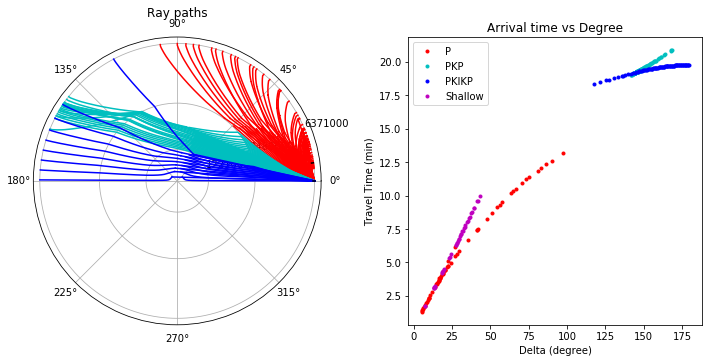

In [21]:
import warnings


deg2rad = 1.0 / 180.0 * np.pi
s2min = 1.0 / 60.0  # convert from second to minute
delta0 = 0.0  # initial position on the circle

def RayPath(_delta0, _fangle, _MYPLANET):
    '''
    Build a complete ray path
    
    Args:
        _delta0(radian): initial angle on the circle
        _fangle(radian): initial incipient angle
        _MYPLANET(PLANETclass)
    '''
    RAY = RAYclass(_MYPLANET, 12)
    # print(RAY.radius.size)
    RAY.propagate(_delta0, _fangle, _MYPLANET.pwavevel)
    # RAY2 is the symetrical half of RAY
    RAY2 = RAYclass(_MYPLANET, 12)
    RAY2.refract(RAY)
    time = RAY.get_total_time() * 2.0 + RAY.extra_time # Time of the ray, which is twice the time for half of the ray
    delta = (RAY.get_end_delta() - _delta0) * 2.0 + RAY.extra_delta # Delta value of the ray
    return delta, time, RAY, RAY2


class RAYPATHGROUP():
    '''
    A Group of raypaths
    '''
    
    def __init__(self, _crucial_fangle_0, _crucial_fangle_1, _crucial_fangle_interval):
        '''
        Initiation
        
        Args:
        _crucial_fangle_0(radian): lower boundary of incipient angles
        _crucial_fangle_1(radian): upper boundary of incipient angles
        _crucial_fangle_interval(radian): interval of incipient angles
        '''
        self.fangles = np.arange(_crucial_fangle_0 , _crucial_fangle_1, _crucial_fangle_interval)
        self.NR = self.fangles.size
        self.RAYs = []  # rays of the first half
        self.RAYs_2 = []  # rays of the second half
        self.Times = np.zeros(self.NR)  # total travel times of rays
        self.Deltas = np.zeros(self.NR)  # total distance in angle
    
    def propagate(self, _delta0, _MYPLANET):
        '''
        Propagate rays in this group from a starting point and a velocity profile

        Args:
            _delta0(float): starting value of angle in radians
            _MYPLANET(PLANETclass): a model for the planet
        '''
        for i in range(self.NR):
            _fangle = self.fangles[i]
            delta, time, RAY, RAY2 = RayPath(_delta0, _fangle, _MYPLANET)  # contruct a single ray path
            self.RAYs.append(RAY)
            self.RAYs_2.append(RAY2)
            self.Times[i] = time
            self.Deltas[i] = delta
    
    def get_times(self):
        '''
        Return times
        
        Returns:
            self.Times(nparray)
        '''
        return self.Times
    
    def get_deltas(self):
        '''
        Return values of deltas
        
        Returns:
            self.Deltas(nparray): Values of travel distrance in radian
        '''
        return self.Deltas

delta, time, RAY, RAY2 = RayPath(0.0, np.pi/2.0, MYPLANET)
extra_delta, extra_time = RAY.get_extra()
assert((delta<1e-6) & (time<1e-6))
with warnings.catch_warnings():
    warnings.simplefilter("error")
    delta, time, RAY, RAY2 = RayPath(0.0, 0.0, MYPLANET)
assert(RAY.end==1)
assert(abs((delta-180.0*deg2rad)/(180.0*deg2rad)) < 1e-6)
    
RayPaths_P = RAYPATHGROUP((_crucial_fangles[2]+0.1)*deg2rad , 85.0*deg2rad, deg2rad)  # P wave
RayPaths_P.propagate(0.0, MYPLANET)
RayPaths_PKP = RAYPATHGROUP((_crucial_fangles[4]+0.1)*deg2rad , (_crucial_fangles[2]-0.1)*deg2rad, 0.05*deg2rad)  # PKP wave
RayPaths_PKP.propagate(0.0, MYPLANET)
RayPaths_PKIKP = RAYPATHGROUP(0.1*deg2rad , (_crucial_fangles[4]-0.1)*deg2rad, 0.1*deg2rad)  # PKIKP wave
RayPaths_PKIKP.propagate(0.0, MYPLANET)
RayPaths_MTZ = RAYPATHGROUP((_crucial_fangles[1]-5.0)*deg2rad , (_crucial_fangles[0])*deg2rad, 0.1*deg2rad)  # MTZ
RayPaths_MTZ.propagate(0.0, MYPLANET)
RayPaths_shallow = RAYPATHGROUP(85.0*deg2rad , 89.0*deg2rad, 0.1*deg2rad)  # shallow P wave
RayPaths_shallow.propagate(0.0, MYPLANET)
print('Shadow Zone: (%.4e deg, %.4e deg)' % (np.max(RayPaths_P.get_deltas())/deg2rad, np.min(RayPaths_PKP.get_deltas())/deg2rad))

# Plotting
fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(121, projection='polar')  # plot ray
for i in range(RayPaths_P.NR):
    # plot the P waves
    plot_ray(ax0, RayPaths_P.RAYs[i], RayPaths_P.RAYs_2[i], color='r')
for i in range(0, RayPaths_PKP.NR, 10):
    # plot the PKP waves
    plot_ray(ax0, RayPaths_PKP.RAYs[i], RayPaths_PKP.RAYs_2[i], color='c')
for i in range(0, RayPaths_PKIKP.NR, 10):
    # plot the P waves
    plot_ray(ax0, RayPaths_PKIKP.RAYs[i], RayPaths_PKIKP.RAYs_2[i], color='b')
    
# # get the maximux time index in shallow P
ind = np.argmin(RayPaths_shallow.get_times())
# plot the max travel time ray in P
print(RayPaths_shallow.RAYs[ind].length)
ax0.plot(RayPaths_shallow.RAYs[ind].get_delta(), RayPaths_shallow.RAYs[ind].get_radius(),'k-')
ax0.plot(RayPaths_shallow.RAYs_2[ind].get_delta(), RayPaths_shallow.RAYs_2[ind].get_radius(),'k-')

RinnerC = 1221e3  # inner core radius
ax0.set_rticks([RinnerC,Rcmb,Rearth])
ax0.set_title("Ray paths")
ax1 = fig.add_subplot(122)
ax1.plot(RayPaths_P.get_deltas()/deg2rad, RayPaths_P.get_times()*s2min, 'r.', label = 'P')
ax1.plot(RayPaths_PKP.get_deltas()/deg2rad, RayPaths_PKP.get_times()*s2min, 'c.', label = 'PKP')
ax1.plot(RayPaths_PKIKP.get_deltas()/deg2rad, RayPaths_PKIKP.get_times()*s2min, 'b.', label = 'PKIKP')
ax1.plot(RayPaths_shallow.get_deltas()/deg2rad, RayPaths_shallow.get_times()*s2min, 'm.', label = 'Shallow')
ax1.set_title("Arrival time vs Degree")
# ax1.set_xlim((0.0, 180.0))
ax1.set_xlabel("Delta (degree)")
ax1.set_ylabel("Travel Time (min)")
ax1.legend()
fig.tight_layout()





## Recreate Figure 17.5 in your book

Plot example P and PKP ray paths.<br>
Plot the arrival times vs. delta (degrees) for several P and PKP paths.<br>
Over what range of delta values is your shadow zone in your simple 1-D model and how does it compare to the textbook?


### a. My shadow zone has delta values between ~92 - ~137 degree, it's roughly the same as in the textbook.
And there is an over kill in my approach. But maybe we can hunt more phases with it, though now there is still some bug that keeping getting delta that is bigger than 180 degree. It's kind of fun. When I have leisure, I can totally improve this to plot S waves as well as other models.

# Next time: 

## Real material equations of state and internal structures

## What is the temperature profile in the Earth?

The Earth\'s surface is about 300 K but the mantle adiabat is much warmer. 
The temperature at the intersection of the mantle adiabat with 1 bar pressure is called the mantle\'s potential 
temperature. The potential temperature is about 1410 degrees C.<p>

The core temperature is not known and is estimated by modeling the thermal structure of the Earth. 
Here is a recent estimate from Anzellini et al., Science, 2013, where the temperature of iron alloy at the core-mantle boundary is about 4050 K:<br>
<img src="./coretemp.png" width="600" >

I used <a href="https://apps.automeris.io/wpd/">WebPlotDigitizer</a> to grab a few (P,T) points from this plot. I also use <a href="https://datathief.org/">DataThief</a>, which is a javascript program you can download.

You can try <a href="https://apps.automeris.io/wpd/">WebPlotDigitizer</a> now.


#END LAB 05